In [1]:
import numpy as np
import pandas as pd
import json
import seaborn as sns

In [2]:
sns.set()

In [3]:
with open('posts.json') as file:
    data_json = json.load(file)

In [5]:
data = {}
data['likes'] = [elem['likes'] for elem in data_json]
data['reposts'] = [elem['reposts'] for elem in data_json]
data['text'] = [elem['text'] for elem in data_json]
data['public'] = [elem['public'] for elem in data_json]
data['date'] = [elem['date'] for elem in data_json]

data = pd.DataFrame(data)
print(data.shape)

data = data.drop_duplicates()
print(data.shape)

import gc
del data_json
gc.collect()

(496468, 5)
(496464, 5)


0

10

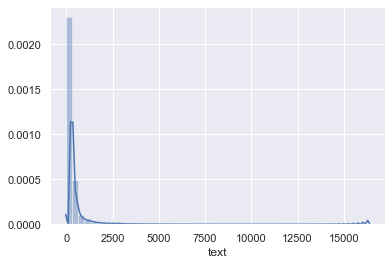

In [6]:
lengths = data.text.str.len()
mask = (lengths > 30) & (lengths < 1500)

data = data[mask]
sns.distplot(lengths)
del mask, lengths
gc.collect()

In [8]:
data.to_csv('liberalnews.csv')

In [11]:
from gensim.models import Doc2Vec
from gensim.models.doc2vec import TaggedDocument
from nltk.tokenize import wordpunct_tokenize

D:\programs\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [93]:
text = data.text.str.lower().apply(wordpunct_tokenize)

In [17]:
corpus = [TaggedDocument(doc, [i]) for i, doc in enumerate(list(text))]

In [70]:
model = Doc2Vec(
    corpus, vector_size=128, window=5, min_count=10, workers=4,
)

In [71]:
from gensim.test.utils import get_tmpfile
fname = get_tmpfile("news")
model.save(fname)

D:\programs\lib\site-packages\smart_open\smart_open_lib.py:398: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [73]:
docvecs = model.docvecs

In [88]:
print(data.text.iloc[6474])
docvecs.most_similar(
    [model.infer_vector(wordpunct_tokenize(data.text.iloc[6474]))]
)

Умершей пенсионерке из Самары чиновники из ПФР велели явиться за социальным пособием на собственные похороны

http://news.lenta.ch/gnKp


[(6474, 0.7253128290176392),
 (36045, 0.6331160068511963),
 (19463, 0.6241316795349121),
 (115831, 0.6212077140808105),
 (158573, 0.6174390316009521),
 (98533, 0.6161640882492065),
 (347510, 0.6142557859420776),
 (267491, 0.6140272617340088),
 (11085, 0.6003265380859375),
 (351070, 0.5982236862182617)]

In [92]:
data.text.iloc[19463]

'• ФСБ установила заказчика теракта в метро Петербурга;\n• В Кремле одобрили идею школьных олимпиад по выборам президента;\n• Путин подписал указ о призыве запасников на военные сборы в 2017 году;\n• Житель Тюмени угнал машину ради поездки на похороны кота\n\nи другие новости к этому часу'

In [26]:
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler

X_tsne = TSNE(n_components=2).fit_transform(embedding)
X_tsne = StandardScaler().fit_transform(X_tsne)

In [27]:
X_tsne.shape

(105384, 2)

In [29]:
np.savetxt('tsne.csv', X_tsne, delimiter=',')

In [30]:
import matplotlib.pyplot as plt

D:\programs\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log
  This is separate from the ipykernel package so we can avoid doing imports until


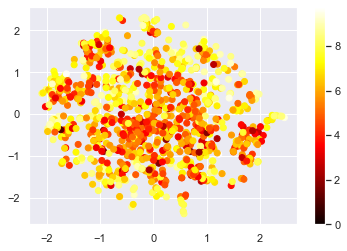

In [46]:
indices = np.random.choice(X_tsne.shape[0], 1000, replace=False)
plt.scatter(
    X_tsne[indices, 0], X_tsne[indices, 1], c=np.log(data.likes.values[indices]),
    cmap='hot'
)

plt.colorbar()

In [40]:
from sklearn.decomposition import PCA

X_pca = PCA(n_components=2).fit_transform(embedding)
X_pca = StandardScaler().fit_transform(embedding)

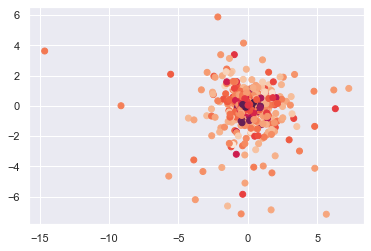

In [43]:
plt.scatter(X_pca[indices, 0], X_pca[indices, 1], c=np.log(data.likes.values[indices]))

In [47]:
import bokeh.models as bm, bokeh.plotting as pl
from bokeh.io import output_notebook
output_notebook()

Loading BokehJS ...

In [48]:
def draw_vectors(x, y, radius=10, alpha=.25, color='blue',
                width=600, height=400, show=True, **kwargs):
    if isinstance(color, str):
        color = [color] * len(x)
    data_source = bm.ColumnDataSource({
        'x': x, 'y': y, 'color': color, **kwargs
    })
    
    fig = pl.figure(active_scroll='wheel_zoom', width=width, height=height)
    fig.scatter('x', 'y', size=radius, 
                color='color', alpha=alpha, source=data_source)
    fig.add_tools(
        bm.HoverTool(tooltips=[(key, "@" + key) for key in kwargs.keys()])
    )
    
    if show:
        pl.show(fig)
    return fig

In [53]:
draw_vectors(X_tsne[indices, 0], X_tsne[indices, 1], token=data.text.values[indices])

Figure(id='1227', ...)

In [50]:
draw_vectors(X_pca[indices, 0], X_pca[indices, 1], token=data.text.values[indices])

Figure(id='1110', ...)

In [51]:
# TSNE on 10000 news

In [57]:
indices = np.random.choice(X_tsne.shape[0], 1000, replace=False)
X_tsne_sampled = TSNE(n_components=2).fit_transform(embedding[indices])
X_tsne_sampled = StandardScaler().fit_transform(X_tsne_sampled)

In [58]:
draw_vectors(X_tsne_sampled[:, 0], X_tsne_sampled[:, 1], token=data.text.values[indices])

Figure(id='1486', ...)

In [64]:
sampled = data.text[2300]

model.most_similar([model.get_vector(sampled)])

KeyError: "word 'ВЦИОМ: Рейтинг доверия Путину обновил исторический минимум, упав до 31,7%.\n\nПри этом президенту по-прежнему доверяют больше, чем другим российским политикам \n\nhttp://news.lenta.ch/dlSe' not in vocabulary"

In [65]:
model.vocab

{'На': <gensim.models.keyedvectors.Vocab at 0x1ebf95f8>,
 '62': <gensim.models.keyedvectors.Vocab at 0xb87a6f28>,
 '-': <gensim.models.keyedvectors.Vocab at 0xb87a60b8>,
 'м': <gensim.models.keyedvectors.Vocab at 0x2a56a0f0>,
 'году': <gensim.models.keyedvectors.Vocab at 0x2a0819b0>,
 'жизни': <gensim.models.keyedvectors.Vocab at 0x2a0815f8>,
 'скончался': <gensim.models.keyedvectors.Vocab at 0xb87a0550>,
 'переводчик': <gensim.models.keyedvectors.Vocab at 0xb87a0f60>,
 'Юрий': <gensim.models.keyedvectors.Vocab at 0xb87a0b00>,
 '.': <gensim.models.keyedvectors.Vocab at 0xb87a02e8>,
 'умер': <gensim.models.keyedvectors.Vocab at 0xb87a03c8>,
 'ещё': <gensim.models.keyedvectors.Vocab at 0xb87a0588>,
 'два': <gensim.models.keyedvectors.Vocab at 0xb87a05f8>,
 'дня': <gensim.models.keyedvectors.Vocab at 0xb87a0240>,
 'назад': <gensim.models.keyedvectors.Vocab at 0xb87a0f98>,
 ',': <gensim.models.keyedvectors.Vocab at 0xb87a01d0>,
 'но': <gensim.models.keyedvectors.Vocab at 0xb87a0e10>,
 'СМИ